In [43]:
import torch
from simulator import Market
from sbi import analysis as analysis
from sbi import utils as utils
from sbi.inference import SNPE, simulate_for_sbi
from sbi.analysis import pairplot
from sbi.utils.user_input_checks import (
    check_sbi_inputs,
    process_prior,
    process_simulator,
)
import numpy as np
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statistics as stats


In [44]:
#pick the true parameters
param_1 = 0.7 #sigma_eta
param_2 = 0.8 #beta
#lower and upper bounds for the prior
param_1_bounds = [0.1, 2]
param_2_bounds = [0.1, 2]
param_1_name = "theta_sigma"
param_2_name = "gamma_sigma"

In [45]:
num_dim = 2
#prior = utils.BoxUniform(low=-2 * torch.ones(num_dim), high=2 * torch.ones(num_dim))
# make an alternative prior with uniform distribution different for each parameter
prior = utils.BoxUniform(low=torch.tensor([param_1_bounds[0], param_2_bounds[0]]),
                          high=torch.tensor([param_1_bounds[1], param_2_bounds[1]]))

def simulator_base(prior_sample):
    #access the first prior value from the tensor
    #create a dcitionary with the prior sample
    params = {param_1_name: float(prior_sample[0]), 
              param_2_name: float(prior_sample[1])}
    #run the market simulation
    market = Market(params)
    while market.step_count < market.total_steps:
        market.next_step()
    #compute the financial market return
    market_return = np.asarray(market.history_p_t)[1:]/np.asarray(market.history_p_t)[:-1] - 1
    # compute the variance, skewness and kurtosis of the market return
    variance = np.var(market_return)
    skewness = np.mean(((market_return - np.mean(market_return)) / np.std(market_return)) ** 3)
    kurtosis = np.mean(((market_return - np.mean(market_return)) / np.std(market_return)) ** 4)
    

    return torch.tensor([skewness, kurtosis])

# def simulator_base(prior_sample):
#     x1 = np.random.normal(0, prior_sample[0], 1000)
#     x2 = np.random.normal(0, prior_sample[1], 1000)
#     x3 = np.random.normal(0, prior_sample[2], 1000)
#     x4 = np.random.normal(0, prior_sample[3], 1000)

#     y = 0.5 + 2 * x1 + 3 * x2 + 4 * x3 + 5 * x4 + np.random.normal(0, 1, 1000)

#     #moments
#     m1 = np.mean(y)
#     m2 = np.var(y)
#     m3 = np.mean((y - m1) ** 3) / (m2 ** (3/2))
#     m4 = np.mean((y - m1) ** 4) / (m2 ** 2) - 3

#     return torch.tensor([m1, m2, m3, m4])


def simulator_returns(prior_sample):
     #access the first prior value from the tensor
    #create a dcitionary with the prior sample
    params = {param_1_name: float(prior_sample[0]), 
              param_2_name: float(prior_sample[1])}
    #run the market simulation
    market = Market(params)
    while market.step_count < market.total_steps:
        market.next_step()
    #compute the financial market return
    market_return = np.asarray(market.history_p_t)[1:]/np.asarray(market.history_p_t)[:-1] - 1
    return torch.tensor(market_return)


In [46]:
# Check prior, return PyTorch prior.
prior, num_parameters, prior_returns_numpy = process_prior(prior)

# Check simulator, returns PyTorch simulator able to simulate batches.
simulator = process_simulator(simulator_base, prior, prior_returns_numpy)

# Consistency check after making ready for sbi.
check_sbi_inputs(simulator, prior)

In [47]:
# Then, we instantiate the inference object
inference = SNPE(prior=prior)

In [48]:
theta, x = simulate_for_sbi(simulator, proposal=prior, num_simulations=1000)

Running 1000 simulations.:   0%|          | 0/1000 [00:00<?, ?it/s]

In [49]:
inference = inference.append_simulations(theta, x)
density_estimator = inference.train(force_first_round_loss=True)

 Neural network successfully converged after 38 epochs.

In [29]:
posterior = inference.build_posterior(density_estimator)

In [40]:
# save the posterior model to a file
torch.save(posterior, 'posterior_model_theta_gamma.pt')

In [41]:
#load the posterior model from a file
posterior1 = torch.load('posterior_model_theta_gamma.pt')

In [50]:
observation = simulator_base(torch.tensor([param_1, param_2]))

Drawing 100000 posterior samples:   0%|          | 0/100000 [00:00<?, ?it/s]

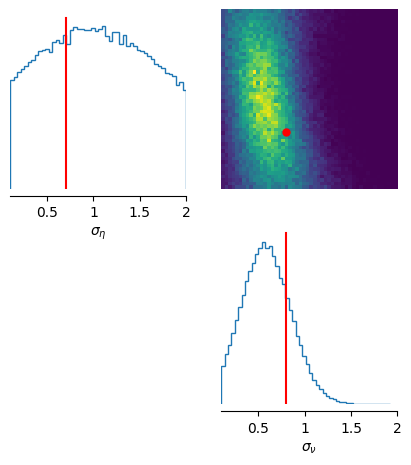

In [51]:
posterior_samples = posterior.sample((100000,), x=observation)

# plot posterior samples
fig, ax = pairplot(
    posterior_samples, limits=[param_1_bounds, param_2_bounds], figsize=(5, 5),
    points=[np.array([param_1, param_2])],
                      points_colors='r', labels=[r'$\sigma_{\eta}$', r'$\sigma_{\nu}$']
)
plt.savefig('Figures/posterior_samples_synthetic.png')

In [52]:
#get the mean, mode, 5% and 95% quantiles of the posterior by leveraging pandas
posterior_samples_df = pd.DataFrame(posterior_samples)
posterior_samples_df.describe()

,0,1
count,100000.000000,100000.000000
mean,1.036044,0.598895
std,0.517142,0.252237
min,0.100001,0.100011
25%,0.608720,0.413243
50%,1.028824,0.585161
75%,1.460136,0.765966
max,1.999948,1.918385


In [53]:
#implied_data = simulator_returns(torch.tensor([theta_sigma, gamma_sigma, epsilon_sigma, ar_1_coefficient])).numpy()
implied_data = simulator_returns(torch.tensor(np.mean(posterior_samples.numpy(), axis=0))).numpy()
actual_data = simulator_returns(torch.tensor([param_1, param_2])).numpy()
#compute skew and kurtosis of the implied data
skew = np.mean(((implied_data - np.mean(implied_data)) / np.std(implied_data)) ** 3)
kurt = np.mean(((implied_data - np.mean(implied_data)) / np.std(implied_data)) ** 4)

#compare with skew and kurtosis of the true data
true_data_skew = observation.numpy().flatten()[0]
true_data_kurt = observation.numpy().flatten()[1]

print("Skewness of the true data: ", true_data_skew)
print("Kurtosis of the true data: ", true_data_kurt)
print("Skewness of the implied data: ", skew)
print("Kurtosis of the implied data: ", kurt)

Skewness of the true data:  0.046160247277891336
Kurtosis of the true data:  3.679225580610125
Skewness of the implied data:  -0.11202610932656787
Kurtosis of the implied data:  3.605139121751941


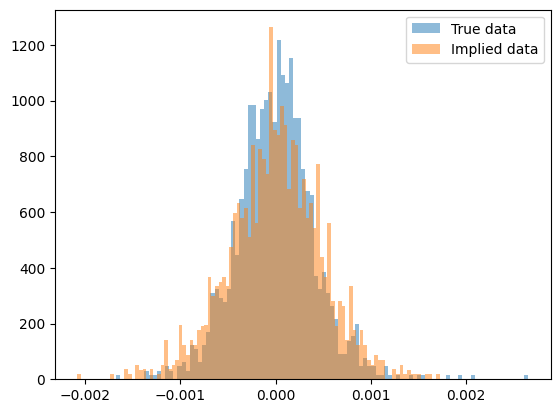

In [54]:
#plot histogram of the true data and the implied data
plt.hist(actual_data, bins=100, alpha=0.5, label="True data", density=True)
plt.hist(implied_data, bins=100, alpha=0.5, label="Implied data", density=True)
plt.legend()

In [55]:
#now we do the estimation on real data

# get the data for the SP500 index on a daily basis
data = yf.download('TSLA', start='2023-09-01', end='2024-10-01')

[*********************100%%**********************]  1 of 1 completed


In [56]:
data.shape

(271, 6)

In [57]:
#compute returns 
data['Return'] = data['Adj Close'].pct_change()

#compute the variance, skewness and kurtosis of the market return
variance = np.var(data['Return'])
skewness = np.mean(((data['Return'] - np.mean(data['Return'])) / np.std(data['Return'])) ** 3)
kurtosis = np.mean(((data['Return'] - np.mean(data['Return'])) / np.std(data['Return'])) ** 4)

real_data = torch.tensor([ skewness, kurtosis])
real_data 


tensor([0.2563, 5.5429], dtype=torch.float64)

In [58]:
samples = posterior.sample((100000,), x=real_data)
# log_probability = posterior.log_prob(samples, x=real_observation)
# _ = analysis.pairplot(samples, limits=[[0.01, 10], [0.01, 10], [0.01, 0.99], [0.01, 0.5],[0.01, 0.5]], figsize=(6, 6))
print(np.median(samples.numpy(), axis=0))

Drawing 100000 posterior samples:   0%|          | 0/100000 [00:00<?, ?it/s]

[1.0766082 1.3318827]


In [59]:
pd.DataFrame(samples).describe()

,0,1
count,100000.000000,100000.000000
mean,1.070090,1.309818
std,0.521200,0.372129
min,0.100036,0.100435
25%,0.640403,1.056880
50%,1.076608,1.331883
75%,1.503616,1.592861
max,1.999941,1.999980


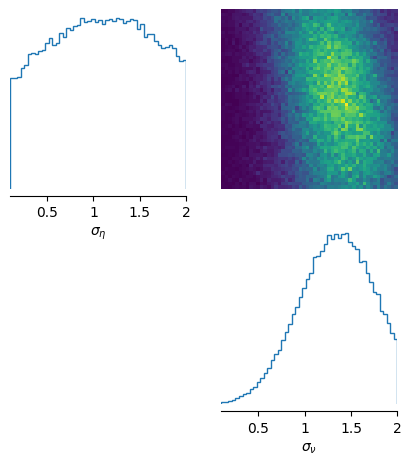

In [60]:
# plot posterior samples
fig, ax = pairplot(
    samples, limits=[param_1_bounds, param_2_bounds], figsize=(5, 5),
    #points=[np.median(samples.numpy(), axis=0)],
                      #points_colors='k',
    labels=[r'$\sigma_{\eta}$', r'$\sigma_{\nu}$']
)
# Save the figure
plt.savefig('Figures/posterior_samples.png')

In [41]:
#compute simulated data for 1000 runs, with those parameters and compare with the real data
implied_data = [simulator_base(np.mean(samples.numpy(), axis=0)) for _ in range(10)]
sim_skew, sim_kurt = np.mean(implied_data, axis=0)


print("Skewness of the true data: ", real_data[0])
print("Kurtosis of the true data: ", real_data[1])
print("Skewness of the implied data: ", sim_skew)
print("Kurtosis of the implied data: ", sim_kurt)



Skewness of the true data:  tensor(0.2563, dtype=torch.float64)
Kurtosis of the true data:  tensor(5.5429, dtype=torch.float64)
Skewness of the implied data:  0.09022911649107371
Kurtosis of the implied data:  5.569257891770996


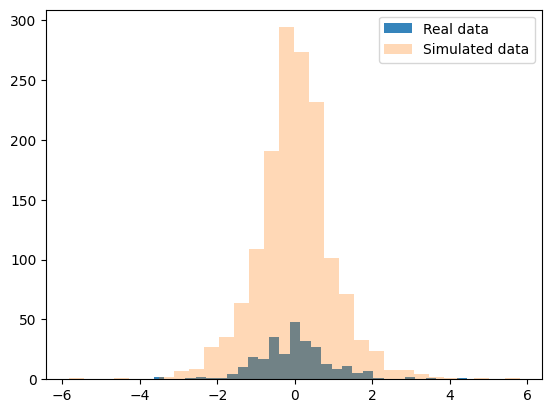

In [42]:
#plot histogram of the real data and the simulated data
simulated_returns = np.array(simulator_returns(np.median(samples.numpy(), axis=0)))
normalized_simulated_data = (simulated_returns - np.mean(simulated_returns)) / np.std(simulated_returns)
normalized_real_data = (data['Return'] - np.mean(data['Return'])) / np.std(data['Return'])
fig, ax = plt.subplots()
ax.hist(normalized_real_data, bins=30, alpha=0.9, label='Real data')
ax.hist(normalized_simulated_data, bins=30, alpha=0.3, label='Simulated data')
#overly a normal distribution with the same mean and variance as the real data
mu = np.mean(normalized_real_data)
sigma = np.std(normalized_real_data)
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
ax.legend()

[ 1.          0.16437315  0.04083586  0.00583699 -0.01492372 -0.01985047
 -0.01048912  0.0036774  -0.02607271 -0.02867493  0.00258862]
[ 1.          0.03154321 -0.0036213   0.14212478 -0.03545402 -0.02389082
  0.00674159 -0.00143836 -0.02815544  0.03523902  0.04053876]


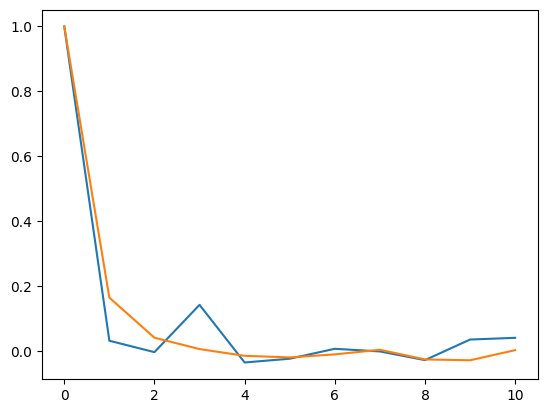

In [24]:
#plot the variance of simulated returns
#print the autocorrelation of the simulated returns squared
print(sm.tsa.acf(simulated_returns**2, nlags=10))
#print the autocorrelation of the real returns squared
print(sm.tsa.acf(data['Return'].dropna()**2, nlags=10))
#plt.plot(data['Return']**2)
plt.plot(sm.tsa.acf(data['Return'].dropna()**2, nlags=10))
plt.plot(sm.tsa.acf(simulated_returns**2, nlags=10))

In [25]:
# check the skewness and kurtosis of the simulated data with and without normalizing
skew_unnormalized = np.mean(((simulated_returns - np.mean(simulated_returns)) / np.std(simulated_returns)) ** 3)
kurt_unnormalized = np.mean(((simulated_returns - np.mean(simulated_returns)) / np.std(simulated_returns)) ** 4)
skew_normalized = np.mean(((normalized_simulated_data - np.mean(normalized_simulated_data)) / np.std(normalized_simulated_data)) ** 3)
kurt_normalized = np.mean(((normalized_simulated_data - np.mean(normalized_simulated_data)) / np.std(normalized_simulated_data)) ** 4)

print("unnorm skew: ", skew_unnormalized)
print("unnorm kurt: ", kurt_unnormalized)
print("norm skew: ", skew_normalized)
print("norm kurt: ", kurt_normalized)

unnorm skew:  -0.03392126729415411
unnorm kurt:  4.56860834159054
norm skew:  -0.03392126729415411
norm kurt:  4.5686083415905445


In [26]:
simulated_returns

array([-8.73147878e-04,  1.77701318e-03, -8.48653536e-04, ...,
        8.42739648e-05, -2.42621938e-04,  6.30450371e-04])

In [27]:
simulated_returns.max(), simulated_returns.min(), normalized_real_data.max(), normalized_real_data.min()

(0.0020575146869175054,
 -0.002344378362986288,
 4.453660683418139,
 -3.6324360167761793)